# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


In [1]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import tensorflow as tf

In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:9999;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

---
## Step 0: Load The Data

In [3]:
# Load pickled data
import pickle
from pandas.io.parsers import read_csv

signnames = read_csv("signnames.csv").values[:,1]

training_file = 'data/train.p'
validation_file = 'data/valid.p'
testing_file = 'data/test.p'

# TODO: DRY
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [4]:
n_train = y_train.shape[0]
n_validation = y_valid.shape[0]
n_test = y_test.shape[0]
image_shape = X_train[0].shape

sign_classes, class_indices, class_counts = np.unique(y_train, return_index=True, return_counts=True)
n_classes = class_counts.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory Visualization of the Dataset

Class 0: Speed limit (20km/h)                                180 samples


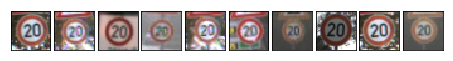

 -------------------------------------------------------------

Class 1: Speed limit (30km/h)                                1980 samples


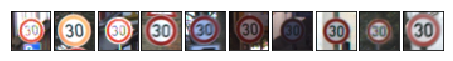

 -------------------------------------------------------------

Class 2: Speed limit (50km/h)                                2010 samples


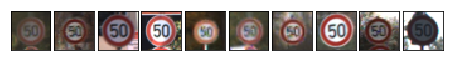

 -------------------------------------------------------------

Class 3: Speed limit (60km/h)                                1260 samples


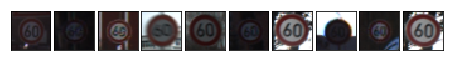

 -------------------------------------------------------------

Class 4: Speed limit (70km/h)                                1770 samples


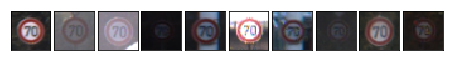

 -------------------------------------------------------------

Class 5: Speed limit (80km/h)                                1650 samples


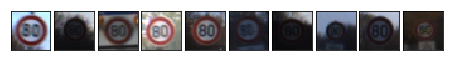

 -------------------------------------------------------------

Class 6: End of speed limit (80km/h)                         360 samples


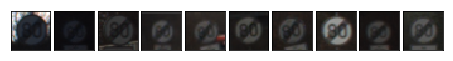

 -------------------------------------------------------------

Class 7: Speed limit (100km/h)                               1290 samples


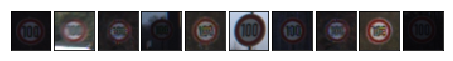

 -------------------------------------------------------------

Class 8: Speed limit (120km/h)                               1260 samples


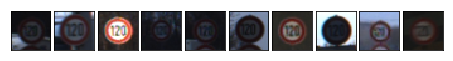

 -------------------------------------------------------------

Class 9: No passing                                          1320 samples


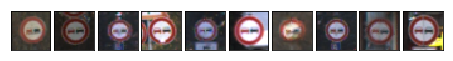

 -------------------------------------------------------------

Class 10: No passing for vehicles over 3.5 metric tons        1800 samples


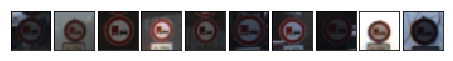

 -------------------------------------------------------------

Class 11: Right-of-way at the next intersection               1170 samples


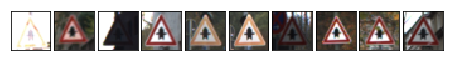

 -------------------------------------------------------------

Class 12: Priority road                                       1890 samples


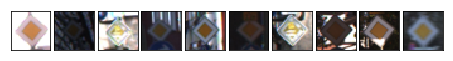

 -------------------------------------------------------------

Class 13: Yield                                               1920 samples


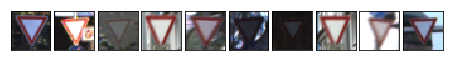

 -------------------------------------------------------------

Class 14: Stop                                                690 samples


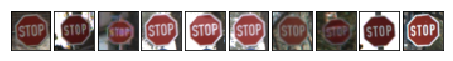

 -------------------------------------------------------------

Class 15: No vehicles                                         540 samples


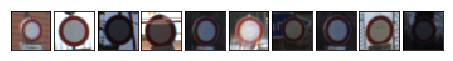

 -------------------------------------------------------------

Class 16: Vehicles over 3.5 metric tons prohibited            360 samples


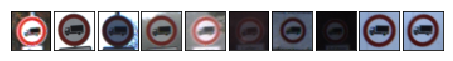

 -------------------------------------------------------------

Class 17: No entry                                            990 samples


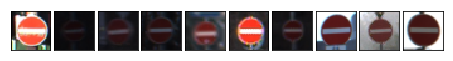

 -------------------------------------------------------------

Class 18: General caution                                     1080 samples


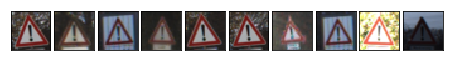

 -------------------------------------------------------------

Class 19: Dangerous curve to the left                         180 samples


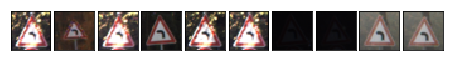

 -------------------------------------------------------------

Class 20: Dangerous curve to the right                        300 samples


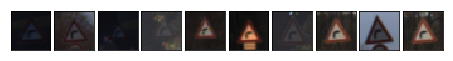

 -------------------------------------------------------------

Class 21: Double curve                                        270 samples


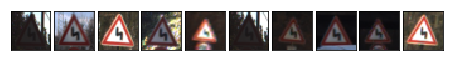

 -------------------------------------------------------------

Class 22: Bumpy road                                          330 samples


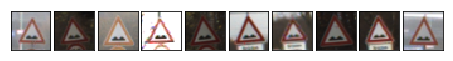

 -------------------------------------------------------------

Class 23: Slippery road                                       450 samples


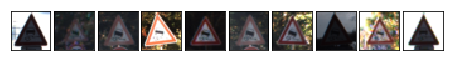

 -------------------------------------------------------------

Class 24: Road narrows on the right                           240 samples


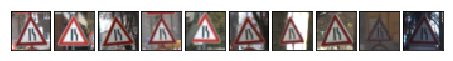

 -------------------------------------------------------------

Class 25: Road work                                           1350 samples


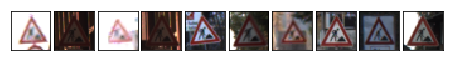

 -------------------------------------------------------------

Class 26: Traffic signals                                     540 samples


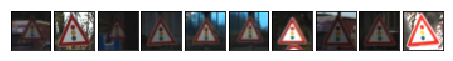

 -------------------------------------------------------------

Class 27: Pedestrians                                         210 samples


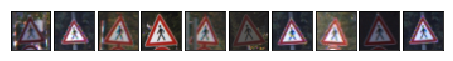

 -------------------------------------------------------------

Class 28: Children crossing                                   480 samples


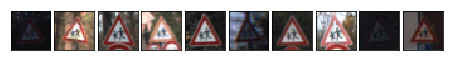

 -------------------------------------------------------------

Class 29: Bicycles crossing                                   240 samples


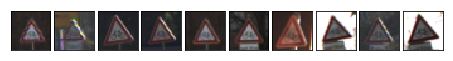

 -------------------------------------------------------------

Class 30: Beware of ice/snow                                  390 samples


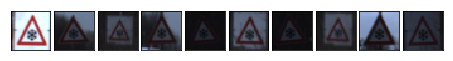

 -------------------------------------------------------------

Class 31: Wild animals crossing                               690 samples


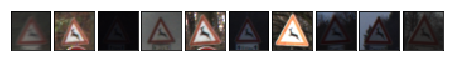

 -------------------------------------------------------------

Class 32: End of all speed and passing limits                 210 samples


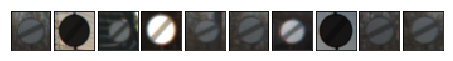

 -------------------------------------------------------------

Class 33: Turn right ahead                                    599 samples


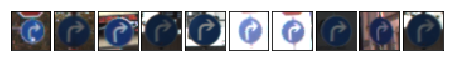

 -------------------------------------------------------------

Class 34: Turn left ahead                                     360 samples


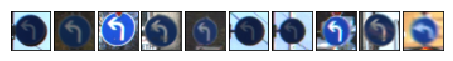

 -------------------------------------------------------------

Class 35: Ahead only                                          1080 samples


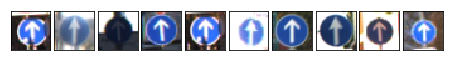

 -------------------------------------------------------------

Class 36: Go straight or right                                330 samples


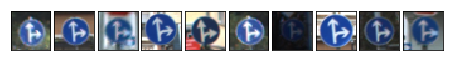

 -------------------------------------------------------------

Class 37: Go straight or left                                 180 samples


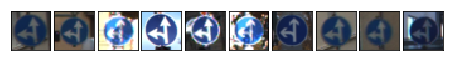

 -------------------------------------------------------------

Class 38: Keep right                                          1860 samples


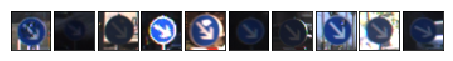

 -------------------------------------------------------------

Class 39: Keep left                                           270 samples


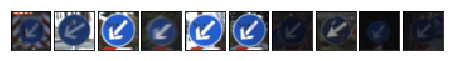

 -------------------------------------------------------------

Class 40: Roundabout mandatory                                300 samples


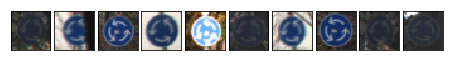

 -------------------------------------------------------------

Class 41: End of no passing                                   210 samples


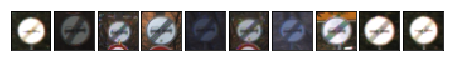

 -------------------------------------------------------------

Class 42: End of no passing by vehicles over 3.5 metric tons  210 samples


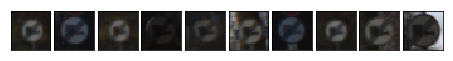

 -------------------------------------------------------------



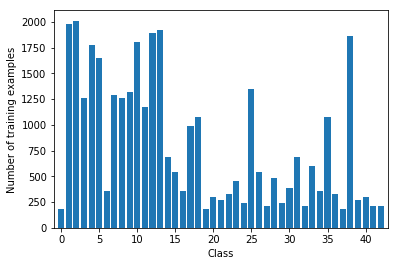

In [5]:
import random

column_width = max(len(name) for name in signnames)

for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    print("Class %i: %-*s  %s samples" % (c, column_width, signnames[c], str(c_count)))
    fig = pyplot.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.1, wspace = 0.1)
    random_indices = random.sample(range(c_index, c_index + c_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train[random_indices[i]])
    pyplot.show()
    print(" -------------------------------------------------------------\n")
    
pyplot.bar(np.arange(43), class_counts, align='center')
pyplot.xlabel('Class')
pyplot.ylabel('Number of training examples')
pyplot.xlim([-1, 43])
pyplot.show()


Overall data volume is less than ideal with some classes with only 180 examples.
This will certently affect the ability of the model to generalise.

One simple solution to our lack of data is to flip signs that are symmetrical in at least one the panes, thus giving us more samples in these classes, for example `Class 40: Roundabout mandatory` or `Class 35: Ahead only`.

Other signs are complementary in nature, like `Class 33: Turn right ahead` and `Class 34: Turn left ahead`, these could be flipped and added to the complementary class.

All of these steps should be done in a data augmentation step as to increase the training set for our CNN.

## Data Augmentation

In [6]:
!pip install nolearn
!pip install scikit-learn --upgrade

Requirement already up-to-date: scikit-learn in /Users/mota/anaconda3/envs/carnd-term1/lib/python3.5/site-packages


In [7]:
import theano
from nolearn.lasagne import BatchIterator
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
import random


class BatchIteratorAugmentedData(BatchIterator):
    """
    Iterates over dataset in batches.
    Allows images augmentation by randomly rotating, applying projection,
    adjusting gamma, blurring, adding noize and flipping horizontally.
    """

    def __init__(self, batch_size, shuffle=False, seed=24, p=0.5, intensity=0.5):
        """
        Initialises an instance with usual iterating settings,
        as well as data augmentation coverage and augmentation intensity.

        Parameters
        ----------
        batch_size: Size of the iteration batch.
        shuffle   : Flag indicating if we need to shuffle the data.
        seed      : Random seed.
        p         : Probability of augmenting a single example,
                    Should be in a range of [0, 1].
                    Defines data augmentation coverage.
        intensity : Augmentation intensity, should be in a [0, 1] range.

        Returns
        -------
        New batch iterator instance.
        """
        super(BatchIteratorAugmentedData, self).__init__(batch_size, shuffle, seed)
        self.p = p
        self.intensity = intensity

    def transform(self, X, Y):
        """
        Applies a pipeline of randomised transformations for data augmentation.
        """
        x = X if Y is None else X.copy()
        X, Y = super(BatchIteratorAugmentedData, self).transform(x, Y)

        if Y is not None:
            batch_size = X.shape[0]
            image_size = X.shape[1]

            X = self.rotate(X, batch_size)
            X = self.apply_projection_transform(X, batch_size, image_size)

        return X, Y

    def rotate(self, X, batch_size):
        """
        Applies random rotation in a defined degrees range to a random subset of images.
        Range itself is subject to scaling depending on augmentation intensity.
        """
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace=False):
            delta = 30.0 * self.intensity  # scale by intensity
            X[i] = rotate(X[i], random.uniform(-delta, delta), mode='edge')
        return X

    def apply_projection_transform(self, X, batch_size, image_size):
        """
        Applies projection transform to a random subset of images.
        Projection margins are randomised in a range depending on the size of the image.
        Range itself is subject to scaling depending on augmentation intensity.
        """
        d = image_size * 0.3 * self.intensity
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace=False):
            tl_top = random.uniform(-d, d)     # Top left corner, top margin
            tl_left = random.uniform(-d, d)    # Top left corner, left margin
            bl_bottom = random.uniform(-d, d)  # Bottom left corner, bottom margin
            bl_left = random.uniform(-d, d)    # Bottom left corner, left margin
            tr_top = random.uniform(-d, d)     # Top right corner, top margin
            tr_right = random.uniform(-d, d)   # Top right corner, right margin
            br_bottom = random.uniform(-d, d)  # Bottom right corner, bottom margin
            br_right = random.uniform(-d, d)   # Bottom right corner, right margin

            transform = ProjectiveTransform()
            transform.estimate(np.array((
                    (tl_left, tl_top),
                    (bl_left, image_size - bl_bottom),
                    (image_size - br_right, image_size - br_bottom),
                    (image_size - tr_right, tr_top)
                )), np.array((
                    (0, 0),
                    (0, image_size),
                    (image_size, image_size),
                    (image_size, 0)
                )))
            X[i] = warp(X[i], transform, output_shape=(image_size, image_size), order=1, mode='edge')

        return X

/Users/mota/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Testing the data augmentation by plotting a few examplest next to the original image

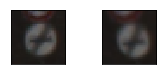

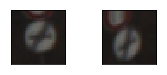

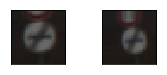

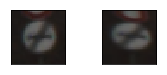

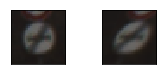

In [8]:
X_train = X_train / 255.0

batch_iterator = BatchIteratorAugmentedData(batch_size = 5, p = 1.0, intensity = 0.75)
for x_batch, y_batch in batch_iterator(X_train, y_train):
    for i in range(5): 
        # plot two images:
        fig = pyplot.figure(figsize=(3, 1))
        axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
        axis.imshow(X_train[i])
        axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
        axis.imshow(x_batch[i])
        pyplot.show()
    break

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [9]:
from sklearn.utils import shuffle
from skimage import exposure
import warnings 

### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def preprocess_data(X, y = None):
    """
    Performs:
    - feature scaling 
    - one-hot encoding of labels 
    - shuffles the data if labels are provided.
    Assumes original data is sorted by labels.
    
    Parameters
    ----------
    X                : ndarray
                       Data array containing feature examples.
    y                : ndarray, optional, defaults to `None`
                       Data labels in index form.
    Returns
    -------
    A tuple of X and y.    
    """
    print("Preprocessing data with {} examples:".format(X.shape[0]))

    # Convert to grayscale
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    
    # Normalizes the data
    X = (X / 255.).astype(np.float32)
        
    for i in range(X.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X[i] = exposure.equalize_adapthist(X[i])
        print_progress(i + 1, X.shape[0])
        
    # One-hot encoding
    if y is not None:  
        y = np.eye(n_classes)[y]
        X, y = shuffle(X, y)

    # Adds a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X, y

43


In [ ]:
# Apply preprocess functions to data

# TODO: consider moving loading data to its own function
#       then load and preprocess here

X_train, y_train = preprocess_data(X_train, y_train)

# TODO: separate train, valid and test data preprocessing into other cells
#       for now leave them here...
X_valid, y_valid = preprocess_data(X_valid, y_valid)
X_test, y_test   = preprocess_data(X_test, y_test)

### Model Architecture

In [ ]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128
### Define your architecture here.
### Feel free to use as many code cells as needed.

def LeNet(x): # TODO: consider renaming x to somehting more meaningful
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: 
    # Convolutional, Input: 32x32x1, Output: 28x28x6
    conv1_w = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding='VALID') + conv1_b
    # Activation
    conv1   = tf.nn.relu(conv1)
    # Pooling: Input: 28x28x6, Output: 14x14x6
    conv1   = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Layer 2: 
    # Convolutional, Input: 14x14x6, Output: 10x10x16
    conv2_w = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_w, strides=[1,1,1,1], padding='VALID') + conv2_b
    # Activation
    conv2   = tf.nn.relu(conv2)
    # Pooling: Input: 28x28x6, Output: 14x14x6
    conv2   = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Flatten: Input: 10x10x16, Output: 5x5x16
    fc0 = flatten(conv2)
    
    # Layer 3:
    # Fully Connected, Input: 400, Output: 120
    fc1_w = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_w) + fc1_b
    # Activation
    fc1   = tf.nn.relu(fc1)
    
    # Layer 4:
    # Fully Connected, Input: 120, Output: 84
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2   = tf.matmul(fc1, fc2_w) + fc2_b
    # Activation
    fc2   = tf.nn.relu(fc2)
    
    # Layer 5:
    # Fully Connected, Input: 84, Output: 43
    fc3_w = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    fc3   = tf.matmul(fc2, fc3_w) + fc3_b

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [1]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")